# Finding Lane Lines on the Road

In [132]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

# Resubmission Notes - Reviewer Comments

**Project Rubric: *Visually, the left and right lane lines are accurately annotated by solid lines throughout most of the video*.**

**Reviewer Comments:**
The left and right lane lines are accurately annotated throughout most of the video. Well done!!
You should still cut out the intersection part of the hough lines.

Some improvements might help your annotations work better on the pipeline.Try to implement these recommendations:

max_line_length that defines the minimum length of a line that will be created.
Increasing min_line_len for Hough Transform will make your lines longer and will have less number of breaks.(this will make the solid annotated line longer in the output)Increasing max_line_gap will allow points that are farther away from each other to be connected with a single line.
threshold increasing(~ 50-60) will rule out the spurious lines.(defines the minimum number of intersections in a given grid cell that are required to choose a line.)
Decreasing the kernel-size in the Gaussian Filter might also help, as this will remove the noise making the image less blurry.
Consider using rho value of 2*


**Project Rubric: Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.**

**Reviewer Comments:** It seems like you forgot to add your reflections about this algorithm..
Please briefly describe the current pipeline you used, along-with the shortcomings(situation where the pipeline might fail or factors that might affect the pipeline) and suggestions for improving this algorithm.


# Resubmission Notes - Nixon's Comments
I have implemented the recommended changes:
   * Changed the Hough Transform parameters for accurate line identification **rho** changed from 1 to 2, **min_line_length** changed from 20 to 50
   * Gaussian Blur kernel size reduced to 3 from 5
   * This additional change has been made by refitting the Region of Interest Masking function

However this didn't help me with the Optional Challenge as the lines still do intersect. The algorithm was successful at filtering out the horizontal lines though.

**Reflections Markdown Added Below**


## Reflection

Quick Note: The only additional function I have introduced is the **Finding Average Slope and Intercept** function *averageSlope(lines)*.

The Pipeline *process_image(image)* does the following sequence of things:
   1. Coverts the image to grayscale
   2. Blurs the image using a Gaussian kernel of size 3 and standard deviation 2
   3. Edge detection using Canny
   4. Find region of interest in the canny edge image 
   5. Use Hough Transform to find lines
      1. The lines returned from Hough function are then passed to **Finding Average Slope and Intercept** function *averageSlope(lines)*
      2. **averageSlope(lines)** does the following: 
         1. Checks and makes sure that the lines array is NOT EMPTY. **This also identifies the case where Hough transform was not able to identify any valid line, or any positive slope lines or any negative slope lines**
         2. It *filters out horizontal slopes*. Key assumption being slope < 0.4 are considered horizontal lines
         3. Identifies positive and negative slope lines and then average the slope of positive and negative slopes respectively
         4. Calculate the intercept "b" as in the equation y = mx + b for all lines
         5. Using the Average Slope "m" and intercept b, recalculate the y values for positive and negative slope lines respectively
         6. Return the combined set of lines to be drawn on to the image
   6. Draw the lane lines on the image

**Drawbacks:**
   * This algorithm will work fine in limited scenarios like it identifies lines when the image doesn't have enough noise lines introduced. 
   * For curves this algorithm will not work well.
   * However I do not think this algorithm is good for real life usage as this is a very limited style of finding lines using Region masking and line drawing. The Roads need not have lanes drawn explicitly all the time and roads need not always have straight lanes. The lane should be more of a non-linear function than a linear function. However the canny edge and Hough transform will help us speedup the advanced algorithms that may be applied. 



## Reviewer Comments on Reflection
Excellent insights have been pointed out and you are on the right path. It is also interesting to point out the need to detect curved lanes.

This research paper http://airccj.org/CSCP/vol5/csit53211.pdf goes into how to detect curves and will also help in detecting faded lanes. It uses an extended version of hough lines algorithm to detect tangents to the curve which can help you detect the curve.

I encourage you to tune your pipeline to implement a better algorithm. You can for example try to implement algorithm provided in this question:
http://stackoverflow.com/questions/36598897/python-and-opencv-improving-my-lane-detection-algorithm


## Graysacle Function

In [133]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## GaussianBlur Function

In [134]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 2)

## Canny Function

In [135]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

## Region of Interest Masking

In [136]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Draw Lines Function 

In [137]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


## Finding Average Slope and Intercept

In [138]:
def averageSlope(lines):
    """
    Find the Avergae Slope and Intercept of Positive and negative lines 
    and then the y values for each vertices are recaluclated to match new slope and intercept values
    """
    if all(lines.shape):
        
        #return variable final_lines 
        error_lines = lines
        line_shape = lines.shape[1:]
        
        lines = np.squeeze(lines)    
                    
        #Find the Slope
        slope = (np.vstack(lines[:,3])-np.vstack(lines[:,1])) / (np.vstack(lines[:,2]) - np.vstack(lines[:,0]))

        #Slope of an horizontal line is zero so eliminate the horizontal lines      
        
        slope_lines = np.abs(slope)>0.4 # Assuming 0.4 is near horizontal
        
        #Find the index of the lines where line has slope value == True,
        slope_lines_index = np.where(slope_lines == True)
        # where funtion returns a tuple with first element being the row indices and second element the column indices
        
           
        #Eliminate the horizontal lines and the slopes
        lines = lines[slope_lines_index[0],:]
        slope = slope[slope_lines_index[0],:]

        if all(lines.shape): 
            #Find the Length of lines
            line_size = np.sqrt((np.vstack(lines[:,2]) - np.vstack(lines[:,0]))**2 + (np.vstack(lines[:,3])-np.vstack(lines[:,1]))**2)
            
            #Finding Positive Slope lines
            positive_slope = slope > 0
            
            #Find the index of the lines where line has slope value == True,
            positive_slope_index = np.where(positive_slope == True)
            
            #Find Positive Lines
            lines_positive = lines[positive_slope_index[0],:]
            
            #Checking if the Positive Slope Index is an Empty array
            
            if all(lines_positive.shape):            
            
                #Find positive slope mean
                positive_slope_mean = np.mean(slope[positive_slope_index[0],:])
            

                
                #Calculate Y intercept b using the Formula b = y - mx for all Positive lines
                #b_intercept_positive = np.mean(np.vstack(lines_positive[:,3])- np.vstack(positive_slope_mean*lines_positive[:,2]))
                b_intercept_positive = np.mean(np.vstack(lines_positive[:,3])- np.vstack(lines_positive[:,2])*slope[positive_slope_index[0],:])
                #p.vstack(lines_positive[:,2])*slope[positive_slope_index[0],:]

                 
                #Modify Y of Positive lines based on the new intercept values

                lines_positive[:,1] = np.reshape(positive_slope_mean*lines_positive[:,0] + b_intercept_positive, lines_positive[:,1].shape)
                lines_positive[:,3] = np.reshape(positive_slope_mean*lines_positive[:,2] + b_intercept_positive, lines_positive[:,3].shape)

            
           
            #Finding Negative Slope lines
            negative_slope = slope < 0
            #Find the index of the lines where line has slope value == True,
            negative_slope_index = np.where(negative_slope == True)      
            lines_negative = lines[negative_slope_index[0],:]
           
            
            #Checking if the Negative Slope Index is an Empty array
            
            if all(lines_negative.shape):               
                
                #Find positive slope mean
                negative_slope_mean = np.mean(slope[negative_slope_index[0],:])
            
            
                #Calculate Y intercept b using the Formula b = y - mx
                #b_intercept_negative = np.mean(np.vstack(lines_negative[:,3])- np.vstack(negative_slope_mean*lines_negative[:,2]))
                b_intercept_negative = np.mean(np.vstack(lines_negative[:,3])- np.vstack(lines_negative[:,2])*slope[negative_slope_index[0],:])
                
                #Modify Y of Positive and negative lines based on the new intercept values
                lines_negative[:,1] = np.reshape(negative_slope_mean*lines_negative[:,0] + b_intercept_negative, lines_negative[:,1].shape)
                lines_negative[:,3] = np.reshape(negative_slope_mean*lines_negative[:,2] + b_intercept_negative, lines_negative[:,3].shape)


            if all(lines_positive.shape) and all(lines_negative.shape):
                #print("Appending Positive and Negative")    
                new_lines = np.append(lines_positive[:],lines_negative[:], axis=0)
            elif not all(lines_positive.shape) and all(lines_negative.shape):
                #print("Positive lines are empty")   
                new_lines = lines_negative
            elif not all(lines_negative.shape) and all(lines_positive.shape):
                #print("Negative lines are empty")   
                new_lines = lines_positive
            elif not all(lines_positive.shape) and not all(lines_negative.shape):
                #print("Positive and Negative lines are empty")   
                return error_lines
              
                   
            #Reshaping the lines to confirm the line function in process_image
            new_lines_shape = new_lines.shape
            newshape = (new_lines_shape[0], line_shape[0],line_shape[1])

            lines = np.reshape(new_lines,newshape)

            return lines
        else:
            new_line_shape = lines.shape
            newshape = (new_line_shape[0], line_shape[0],line_shape[1])

            lines = np.reshape(lines,newshape)
            return lines
         
    else:
        #print("Exiting LengthSlope function as lines is empty")
        return lines


# Hough Transform

In [139]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    #Find Average Slope and Intercept of lines and Recalculate the Y values
    
    lines = averageSlope(lines)
    
    #Draw lines
    draw_lines(line_img, lines)
    return line_img

## Combine Image

In [140]:
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Process Image Function

In [141]:
def process_image(image):
    
    #Make a copy of Image
    output_image = np.copy(image)
    
    # Convert the image to grayscale
    gray = grayscale(image)
    
    #Call Gaussian smoothing / blurring function
    blur_gray = gaussian_blur(gray, 3)
    
    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Define the vertices of the polygon to mask
    imshape = image.shape
    #vertices = np.array([[(50,imshape[0]),(imshape[1]/2 -10, imshape[0]/2), (imshape[1]/2 +10, imshape[0]/2), ((imshape[1]-50),imshape[0])]], dtype=np.int32)
    vertices = np.array([[(50,imshape[0]),(imshape[1]/2 -30, imshape[0]/2+50), (imshape[1]/2 +30, imshape[0]/2+50),((imshape[1]-50),imshape[0])]], dtype=np.int32)

    #Call Region of Interest Masking function    
    masked_edges = region_of_interest(edges, vertices)
    
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = 2*(np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 55     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line
    max_line_gap = 150    # maximum gap in pixels between connectable line segments
       
        
    lines_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    output_image = weighted_img(lines_image, image, α=0.8, β=1., λ=0.)
    
    return output_image

# Testing Images

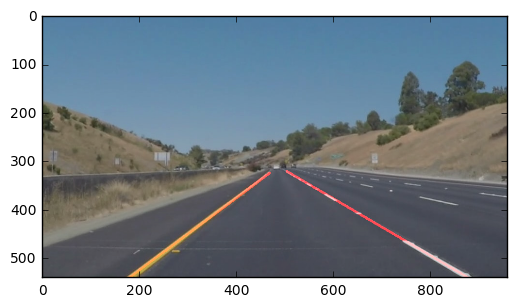

In [142]:
#Test on one Image
plt.imshow(process_image(mpimg.imread('test_images/whiteCarLaneSwitch.jpg')), cmap='Greys_r')

## Testing on a pipleline of images

In [143]:
#Reading in pipleine of images and Saving 

list_image = os.listdir("test_images/")
print(list_image)

for i in list_image:
    #Reading Image
    image = mpimg.imread('test_images/'+str(i))
    #Drawing lines
    output_image = process_image(image)
    mpimg.imsave('test_images/'+(str(i)+'_detected.jpg'), output_image)
    


['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


# Test on Videos

In [144]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [145]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:10<00:00, 15.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12.5 s


In [146]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [147]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:27<00:00, 25.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 28.1 s


In [148]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Optional Challenge

In [149]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:20<00:00, 12.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 22.9 s


In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))